In [5]:
%load_ext autoreload
%autoreload 2

from models import Darknet, load_classes
from utils.utils import *
import torch

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
config_path='config/yolov3.cfg'
# weights_path='./15.weights'
weights_path = './checkpoints/1.weights'
class_path='config/dwg.names'
img_size = 512

# Load model and weights
model = Darknet(config_path)
model.load_weights(weights_path)

model.eval()
classes = load_classes(class_path)
Tensor = torch.FloatTensor

C:\Users\mihanick.MCAD\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [7]:
from utils.datasets import ListDataset

dataloader = torch.utils.data.DataLoader(
    ListDataset('./data/dwg/train.txt', max_objects=87), batch_size=4, shuffle=False
)

[None, None, None, None]


<Figure size 432x288 with 0 Axes>

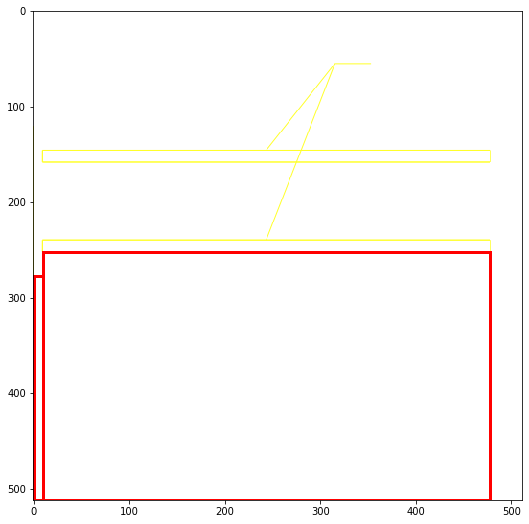

None

[None, None, None, None]


<Figure size 432x288 with 0 Axes>

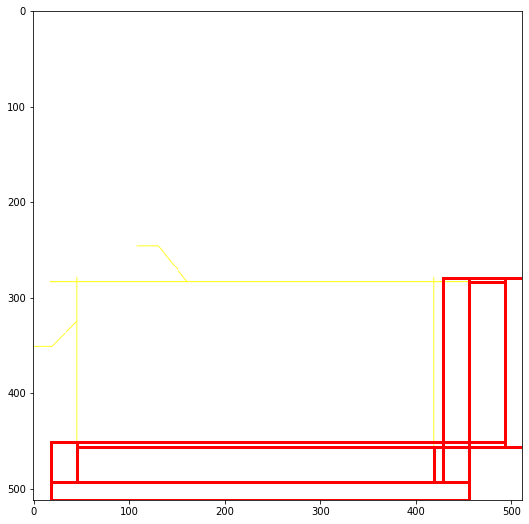

None

[None, None, None, None]


<Figure size 432x288 with 0 Axes>

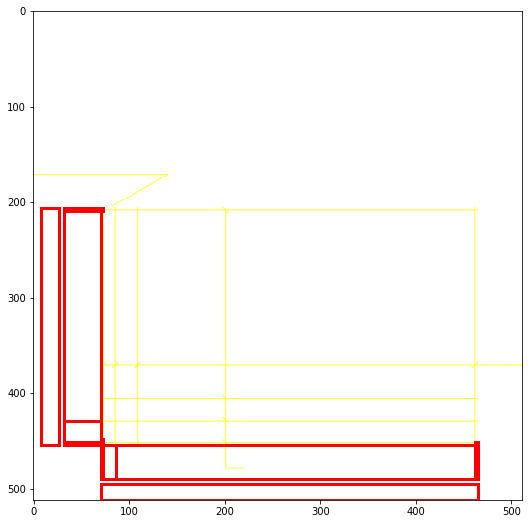

None

[None, None, None, None]


<Figure size 432x288 with 0 Axes>

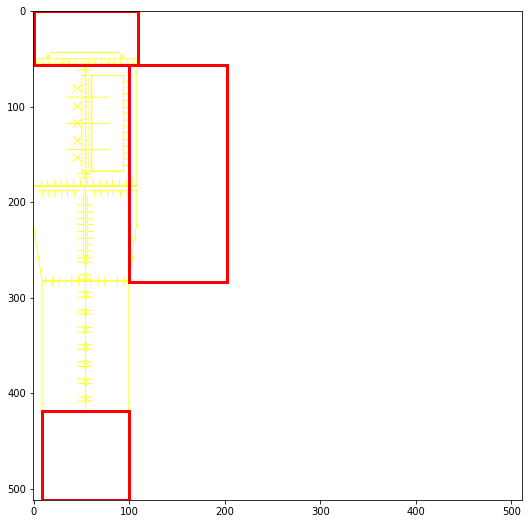

None

[None, None, None, None]


<Figure size 432x288 with 0 Axes>

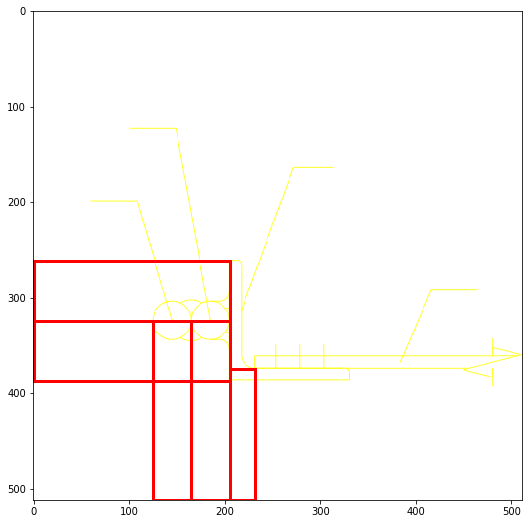

None

[None, None, None, None]


<Figure size 432x288 with 0 Axes>

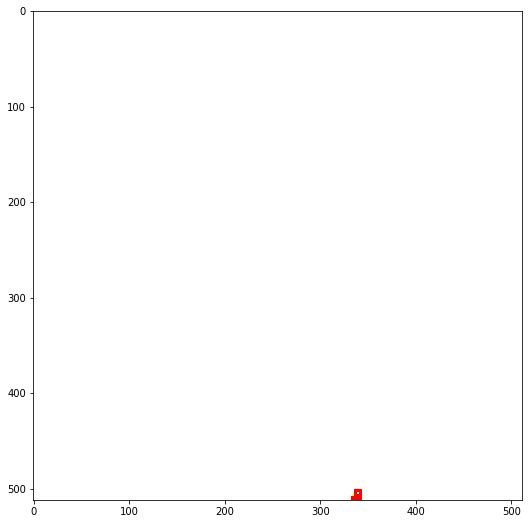

None

In [9]:
from models import CalculatePrediction
from utils.utils import PlotImageAndPrediction
from plot_graphics import generate_file2
from IPython import display
import os

shown_samples, max_number_samples = 0, 5

det = None
for batch_i, (file_names, imgs, targets) in enumerate(dataloader):
    dets = CalculatePrediction(model=model, batch_of_images=imgs)
    for i, _img in enumerate(imgs):
        print(dets)
        det = dets[i]
        trg = targets[i]
        display.display(PlotImageAndPrediction(image=_img, target=trg, detections=det))
        
        # check whether input targets are correct
        # file_id = os.path.splitext(os.path.split(file_names[i])[1])[0]
        # d, _ = generate_file2(file_id=file_id, draw_dimensions=True, draw_texts=False, save_file=False)
        # display.display(d)
        shown_samples += 1
        if shown_samples > max_number_samples: break
    if shown_samples > max_number_samples: break